# Master Thesis - Vignoli Lorenzo

---

## 🐙 Helyx training

## ⚙️ Import Libraries

In [1]:
# Colab option
COLAB = False
if COLAB:
    from google.colab import drive
    from google.colab import files

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/Master Thesis

# Core libraries
import os
import random
import logging
import warnings
from datetime import datetime

# Numerics & data
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Image and plotting
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.get_logger().setLevel(logging.ERROR)

# Reproducibility
seed = 1
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# System info
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Plotting
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Other libraries
import glob
import math
import shutil  # to remove directories
import subprocess

2025-03-28 10:12:27.465038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 10:12:27.638441: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-28 10:12:29.907469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 10:12:29.939546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 10:12:29.941037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## ⏳ Load and process the Data

In [2]:
if False:
    # Remove unused directories
    if os.path.exists("images"):
        shutil.rmtree("images")
    if os.path.exists("labels"):
        shutil.rmtree("labels")

    # Create output directories for extracted images and labels
    os.makedirs("images", exist_ok=True)
    os.makedirs("labels", exist_ok=True)

    # Get all dataset files matching the pattern
    dataset_files = sorted(glob.glob("Dataset*.npz"))

    # Initialize global index for consistent file naming
    global_index = 0

    for file in dataset_files:
        print(f"Processing {file}...")

        # Load image and label data from the current dataset
        data = np.load(file)
        X_images = data['X_images']
        y = data['y']

        # Save each image and its corresponding label
        for i in range(len(X_images)):
            image_filename = os.path.join("images", f"img_{global_index:06d}.png")
            label_filename = os.path.join("labels", f"label_{global_index:06d}.npy")

            Image.fromarray(X_images[i]).save(image_filename)
            np.save(label_filename, y[i])

            global_index = global_index + 1

        del X_images
        del y

    print(f"Finished: saved {global_index} images and labels.")

In [3]:
# Load image and label paths (we put them in os)
print("Loading file paths and labels...")
image_paths = sorted([os.path.join('images', f) for f in os.listdir('images') if f.endswith('.png')])
label_paths = sorted([os.path.join('labels', f) for f in os.listdir('labels') if f.endswith('.npy')])
assert len(image_paths) == len(label_paths)
print(f"Loaded {len(image_paths)} images and {len(label_paths)} labels.")

Loading file paths and labels...
Loaded 2000 images and 2000 labels.


In [4]:
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    image_paths, label_paths, test_size=0.05, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=0.1, random_state=seed
)
print("Data splitted!")

Splitting data...
Data splitted!


In [5]:
def load_single_image(image_path, label_path, input_size=(480, 640)):
    # Load and process image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)

    # Load label (regression vector)
    label = tf.numpy_function(np.load, [label_path], tf.float32)
    label.set_shape([6])

    return image, label

In [6]:
def make_dataset(image_paths, label_paths, batch_size=1, shuffle=True, seed=seed):
    """
    Create a clean TensorFlow dataset for image regression (6 float labels).
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    shuffle=True
)
# train_img and train_lbl are already the indexes that we needed before!

val_dataset = make_dataset(
    val_img, val_lbl,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1): # output of the data loader is a batch, so we take (1)
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Creating datasets...


2025-03-28 10:12:30.029170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Datasets created!

Input shape: (480, 640, 3)
Images shape: (1, 480, 640, 3)
Labels shape: (1, 6)


2025-03-28 10:12:30.029890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 10:12:30.031573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 10:12:30.033600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 10:12:30.202475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-28 10:12:30.204206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## ⚓ Network definition

In [8]:
@tf.keras.utils.register_keras_serializable()
class GreenFilter(tfkl.Layer):
    def call(self, inputs):
        hsv = tf.image.rgb_to_hsv(inputs)
        h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
        mask = tf.logical_and(
            tf.logical_and(h > 0.25, h < 0.45),
            tf.logical_and(s > 0.3, v > 0.2)
        )
        return tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)


@tf.keras.utils.register_keras_serializable()
class BlueFilter(tfkl.Layer):
    def call(self, inputs):
        hsv = tf.image.rgb_to_hsv(inputs)
        h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
        mask = tf.logical_and(
            tf.logical_and(h > 0.55, h < 0.75),
            tf.logical_and(s > 0.3, v > 0.2)
        )
        return tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)


@tf.keras.utils.register_keras_serializable()
class RedFilter(tfkl.Layer):
    def call(self, inputs):
        hsv = tf.image.rgb_to_hsv(inputs)
        h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
        lower_red = tf.logical_and(h < 0.05, s > 0.3)
        upper_red = tf.logical_and(h > 0.95, s > 0.3)
        mask = tf.logical_and(tf.logical_or(lower_red, upper_red), v > 0.2)
        return tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)


@tf.keras.utils.register_keras_serializable()
class BlackFilter(tfkl.Layer):
    def call(self, inputs):
        hsv = tf.image.rgb_to_hsv(inputs)
        v = hsv[..., 2]
        mask = v < 0.3
        return tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)

In [9]:
def residual_block(x, filters, kernel_size=3, stack=1, downsample=True, name='res'):
    for s in range(stack):
        skip = x
        x = tfkl.Conv2D(filters, kernel_size, padding='same')(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.Activation('relu')(x)
        x = tfkl.Dropout(0.4)(x)

        x = tfkl.Conv2D(filters, kernel_size, padding='same')(x)
        x = tfkl.BatchNormalization()(x)

        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding='same')(skip)
            skip = tfkl.BatchNormalization()(skip)

        x = tfkl.Add()([x, skip])
        x = tfkl.Activation('relu')(x)
        x = tfkl.Dropout(0.4)(x)

    if downsample:
        x = tfkl.MaxPooling2D(pool_size=2)(x)
    return x

In [10]:
def inception_block(x, filters, stack=1, name='incept'):
    for s in range(stack):
        conv1 = tfkl.Conv2D(filters // 4, 1, padding='same', activation='relu')(x)

        conv3 = tfkl.Conv2D(filters // 8, 1, padding='same', activation='relu')(x)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding='same', activation='relu')(conv3)

        conv5 = tfkl.Conv2D(filters // 8, 1, padding='same', activation='relu')(x)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding='same', activation='relu')(conv5)

        pool = tfkl.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding='same', activation='relu')(pool)

        x = tfkl.Concatenate()([conv1, conv3, conv5, pool_proj])
        x = tfkl.Dropout(0.4)(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)
    return x

In [11]:
def net_camera(number):
    inp = tfk.Input(shape=(480, 640, 3), name=f'input_{number}')
    x = tfkl.RandomBrightness(0.2)(inp)
    x = tfkl.RandomContrast(0.2)(x)
    x = tfkl.Rescaling(1./255)(x)

    x_green = GreenFilter()(x)
    x_blue  = BlueFilter()(x)
    x_black = BlackFilter()(x)
    x_red   = RedFilter()(x)

    x_green = residual_block(x_green, 4, name=f'res_green_{number}')
    x_blue = residual_block(x_blue, 4, name=f'res_blue_{number}')
    x_black = residual_block(x_black, 4, name=f'res_black_{number}')
    x_red   = residual_block(x_red, 4, name=f'res_red_{number}')
    x = residual_block(x, 4, name=f'res_global_{number}')
    x = tfkl.Concatenate(name=f'concat_{number}')([x, x_green, x_blue, x_black, x_red])

    x = residual_block(x, 128, name=f'res_1_{number}')
    x = tfkl.Dropout(0.1)(x)
    x = residual_block(x, 256, name=f'res_2_{number}')
    x = tfkl.Dropout(0.1)(x)
    x = inception_block(x, 128, stack=3, name=f'incept0_{number}')
    x = tfkl.Dropout(0.1)(x)
    x = inception_block(x, 256, name=f'incept2_{number}')
    x = tfkl.Dropout(0.3)(x)
    x = tfkl.GlobalMaxPooling2D(name=f'global_avg_{number}')(x)
    x = tfkl.Dropout(0.2)(x)
    x = tfkl.Dense(128, activation='relu')(x)

    return inp, x

In [12]:
@tf.keras.utils.register_keras_serializable()
class BalancedMSE(tf.keras.losses.Loss):
    def __init__(self, name="balanced_mse"):
        super().__init__(name=name)

        # Normalize and reweight: xyz / 100 → ×√3; angles / π → ×1
        self.weights = tf.constant([
            3.0 / (100.0 ** 2),
            3.0 / (100.0 ** 2),
            3.0 / (100.0 ** 2),
            1.0 / (math.pi ** 2),
            1.0 / (math.pi ** 2),
            1.0 / (math.pi ** 2)
        ], dtype=tf.float32)

    def call(self, y_true, y_pred):
        diff = y_pred - y_true
        mse = tf.square(diff)
        weighted_mse = mse * self.weights
        return tf.reduce_mean(weighted_mse)

Model: "HelyxModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_brightness (RandomBrigh  (None, 480, 640, 3)  0          ['input_1[0][0]']                
 tness)                                                                                           
                                                                                                  
 random_contrast (RandomContras  (None, 480, 640, 3)  0          ['random_brightness[0][0]']      
 t)                                                                                      

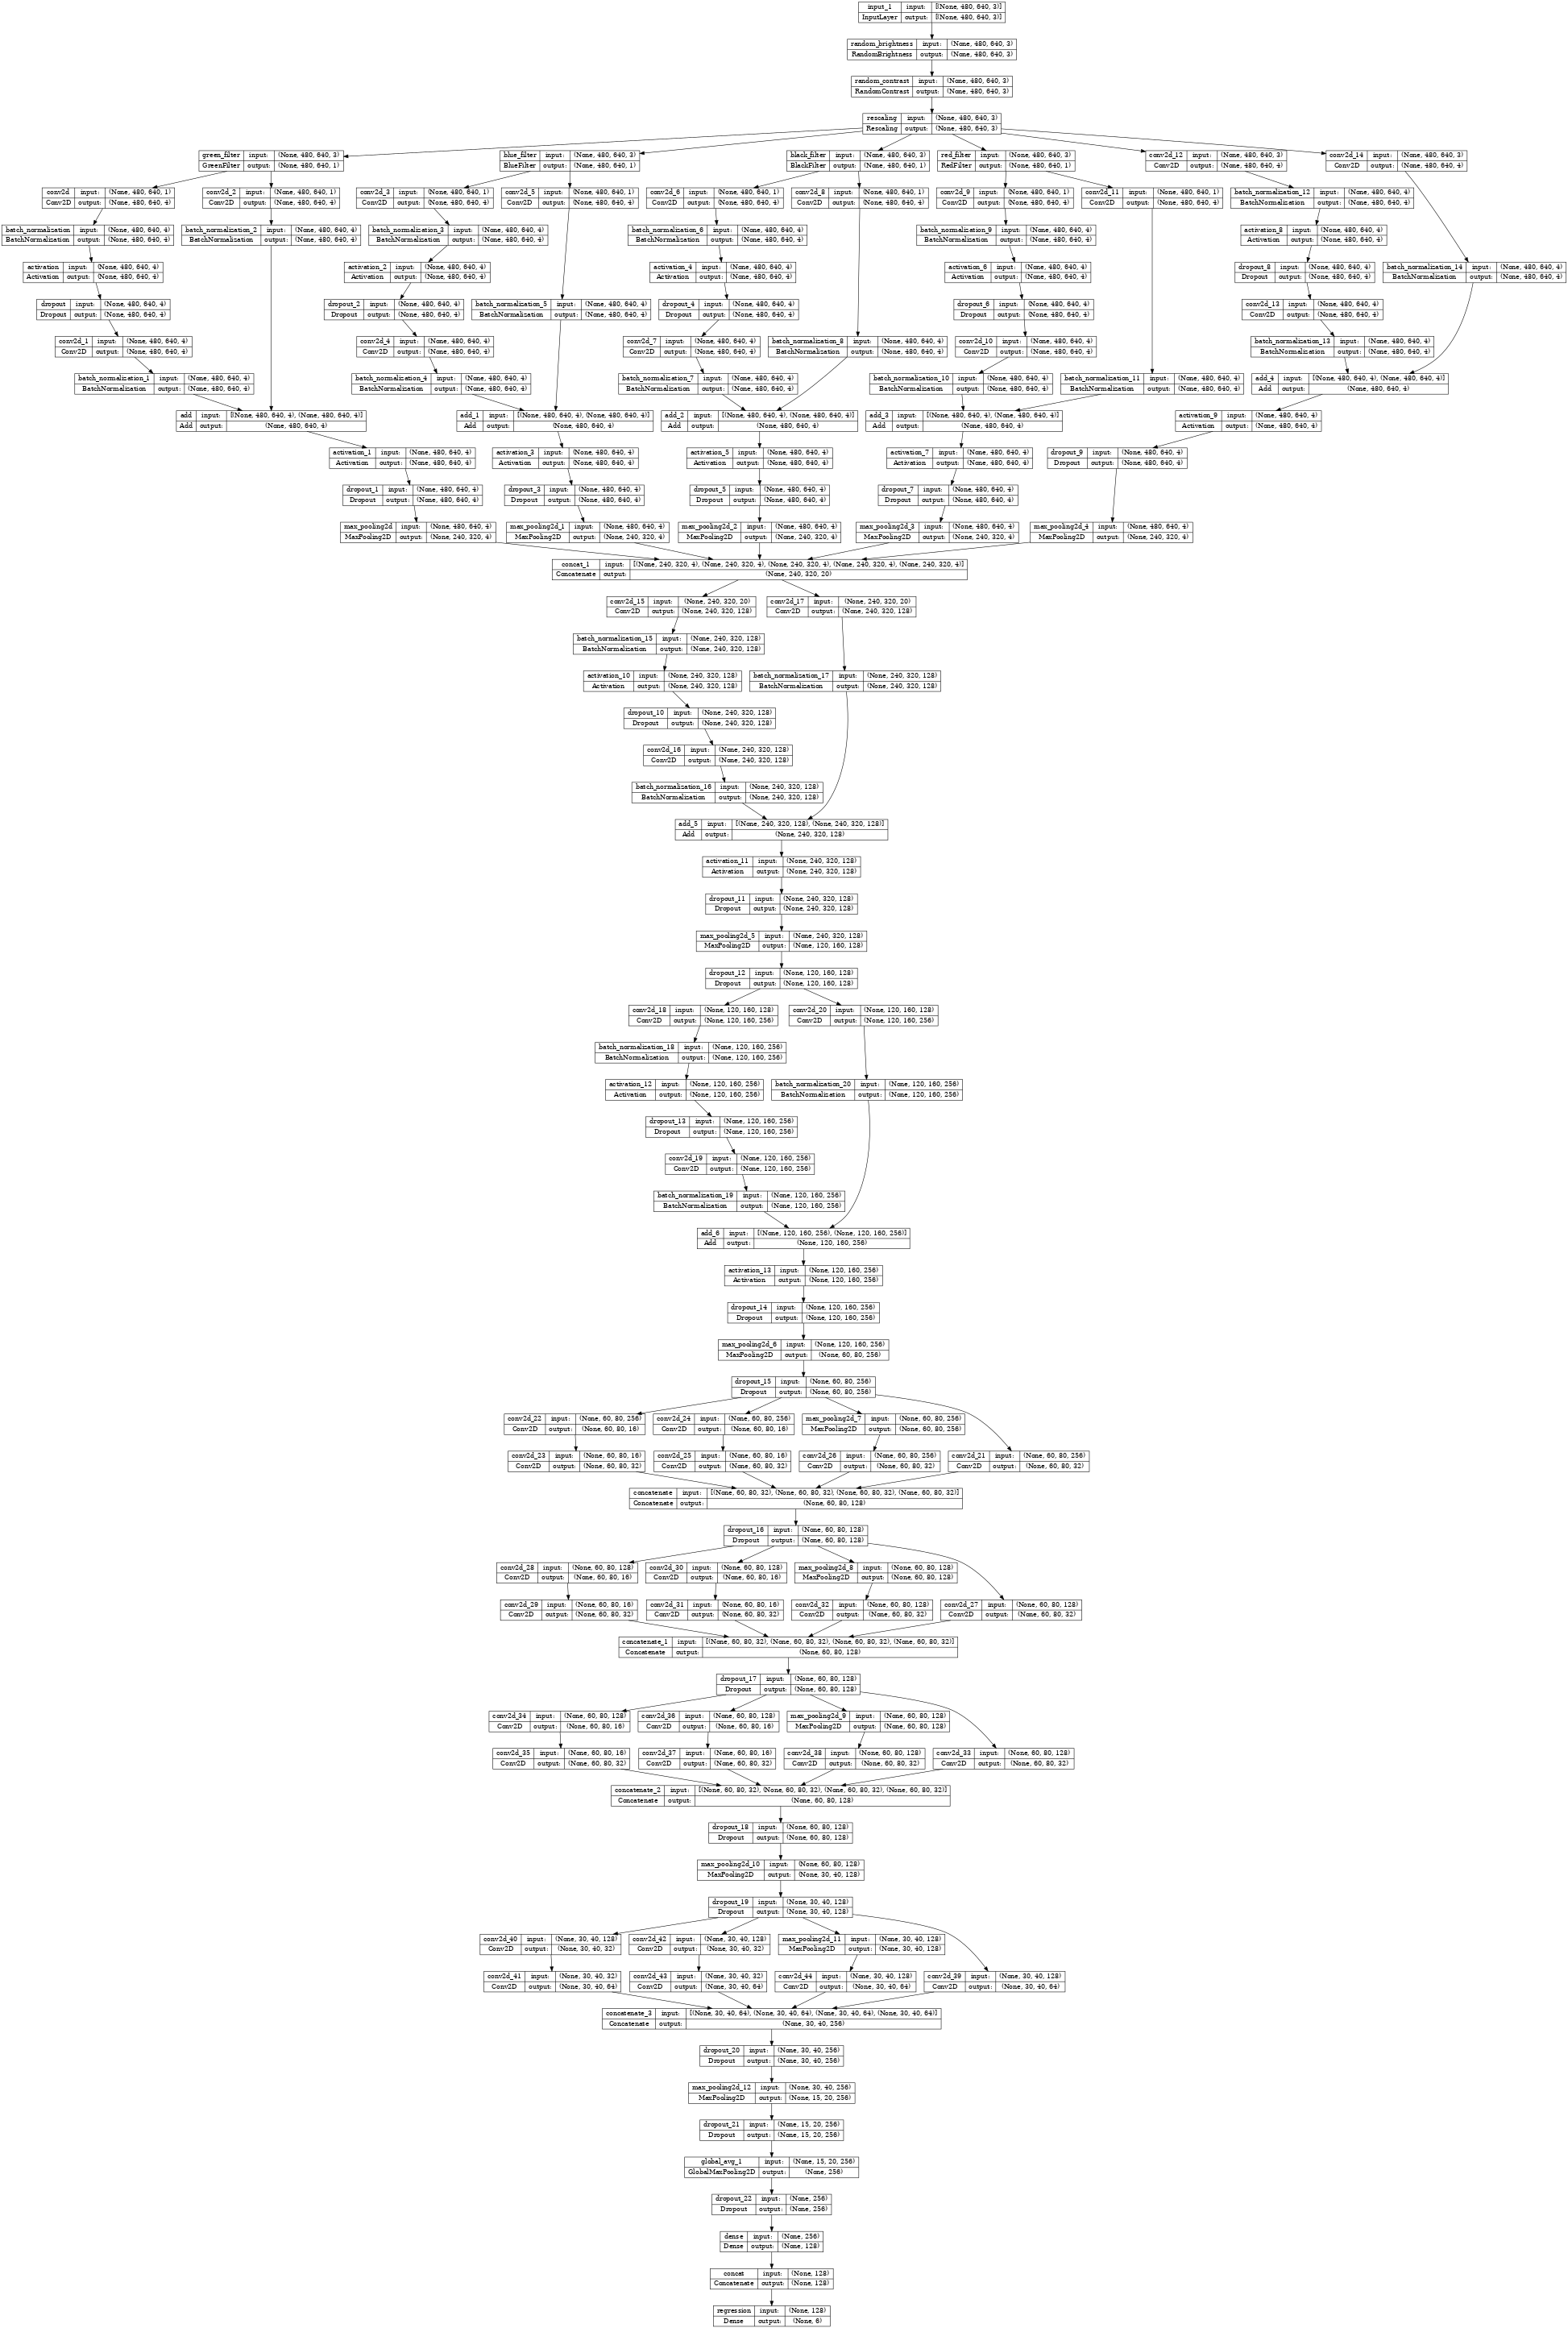

: 

In [ ]:
# Number of cameras
N_cameras = 1

# Collect inputs and latent vectors
inputs, latents = zip(*[net_camera(i) for i in range(1, N_cameras + 1)])

# Concatenate latent vectors
x = tfkl.Concatenate(name='concat')(latents)

# Final dense regression
outputs = tfkl.Dense(6, activation='linear', name='regression')(x)

# Define model
model = tfk.Model(inputs=inputs, outputs=outputs, name="HelyxModel")

# Compile with weighted MAE
model.compile(
    loss=BalancedMSE(),
    optimizer=tfk.optimizers.Adam(decay = 5e-4, learning_rate = 1e-3),
    metrics=["mse"]
)

# Summary
model.summary()
PLOT = True
tfk.utils.plot_model(model, show_shapes=True, expand_nested=False,
                     dpi=40)

## 😓 Training

In [ ]:
# Early stopping to prevent overfitting
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=10,
    restore_best_weights=True
)

Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    callbacks=[early_stopping, Plateau],
    shuffle=True,
    verbose=1
)

# Calculate and print the best MAE achieved
final_val_MSE = round(min(history.history['val_mse']), 2)
print(f'Final validation MSE: {final_val_MSE}')

# Save trained model
model.save("helyx_model.keras")
del model

Epoch 1/1000


In [ ]:
# Create figure and subplots for MSE and MAE
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))

# Plot MSE for training and validation
ax1.plot(history.history['mse'], label='Train MSE', alpha=0.8, color='#ff7f0e')
ax1.plot(history.history['val_mse'], label='Validation MSE', alpha=0.8, color='#4D61E2')
ax1.set_title('Mean Squared Error (MSE)')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## ⏰ Testing

In [ ]:
# Load the saved model
model = tfk.models.load_model("helyx_model.keras", compile=False)

model.compile(
    loss=BalancedMSE(),
    optimizer=tfk.optimizers.Adam(decay = 5e-4, learning_rate = 1e-3),
    metrics=["mse"]
)

# Evaluate the model on the test dataset
results = model.evaluate(test_dataset, verbose=1)
test_loss, test_mse = results
print(f"Test MSE: {round(test_mse, 4)}")

# Predict all test outputs
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_true.append(y_batch.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5, s=10)
    plt.plot([y_true[:, i].min(), y_true[:, i].max()],
             [y_true[:, i].min(), y_true[:, i].max()], 'r--')
    plt.title(f'Param {i+1}')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
dim_labels = ['x', 'y', 'z', 'Z', 'Y', 'X']
num_outputs = y_true.shape[1]
fig, axes = plt.subplots(1, num_outputs, figsize=(num_outputs * 4, 4))

for i in range(num_outputs):
    ax = axes[i] if num_outputs > 1 else axes
    ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
    ax.set_xlabel(f'True {dim_labels[i]}')
    ax.set_ylabel(f'Predicted {dim_labels[i]}')
    ax.set_title(f'True vs Predicted ({dim_labels[i]})')
    lims = [min(y_true[:, i].min(), y_pred[:, i].min()), max(y_true[:, i].max(), y_pred[:, i].max())]
    ax.plot(lims, lims, '--', color='red')  # identity line

plt.tight_layout()
plt.show()